In [2]:
from catalogue import *

In [3]:
inputs, outputs, error, df_original = load_data()
print "Number of stars:", inputs.shape[0]
print "Shape of inputs, outputs, and error from loading data..."
print inputs.shape, outputs.shape, error.shape

/opt/conda/lib/python2.7/site-packages/pandas/core/frame.py:5082: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


Number of stars: 142750
Shape of inputs, outputs, and error from loading data...
(142750, 9) (142750, 3) (142750, 3)


In [4]:
inputs['u-g'] = inputs['u'].subtract(inputs['g'])
inputs['u-i'] = inputs['u'].subtract(inputs['i'])
inputs['g-r'] = inputs['g'].subtract(inputs['r'])
inputs['g-z'] = inputs['g'].subtract(inputs['z'])

m = 0.42 # u - g
b = 0.3 # g - r

# Apply a color cut to remove the contaminent stars (i.e. that are not giants or dwarfs)
colour_cut_a = (m*inputs['u-g'] - b > inputs['g-r'])
colour_cut_b = (m*inputs['u-g'] - b <= inputs['g-r'])


a_star=inputs[colour_cut_a]
outputs=outputs[colour_cut_b] # 0.42*(u-g)-0.3 <= (g-r) 
error=error[colour_cut_b] # 0.42*(u-g)-0.3 <= (g-r) 
inputs=inputs[colour_cut_b] # 0.42*(u-g)-0.3 <= (g-r) 

print "Number of stars after colour cut:", inputs.shape[0]

Number of stars after colour cut: 132159


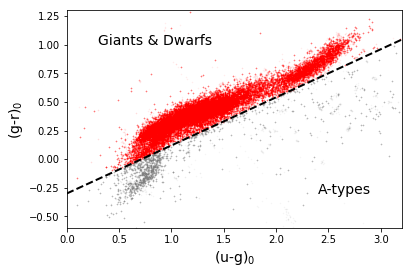

In [5]:
#plt.figure(figsize=(10,8))
plt.scatter(inputs['u-g'], inputs['g-r'], s=0.5, c="red",alpha=0.05,edgecolors=None, cmap=plt.cm.RdBu,rasterized=True)
plt.scatter(a_star['u-g'], a_star['g-r'], s=0.5, c='grey',alpha=0.05,edgecolors=None, cmap=plt.cm.RdBu,rasterized=True)
line=np.arange(0.0,3.5,0.002)
plt.plot(line,0.42*line-0.3,"k--",lw=2)
plt.xlabel('(u-g)$_0$',fontsize=14)
plt.ylabel('(g-r)$_0$',fontsize=14)
plt.xlim(0.0,3.2)
plt.ylim(-0.6,1.3)
plt.ylabel('(g-r)$_0$')
plt.annotate(r"Giants & Dwarfs", xy=(0.3,1.0), xytext=(0.3, 1.0), color='black',size=14)
plt.annotate(r"A-types", xy=(2.4,-0.3), xytext=(2.4, -0.3), color='black',size=14)

plt.rcParams['pdf.fonttype']=42
plt.savefig("color_color_ML.pdf", format='pdf')
plt.show()

In [6]:
# Apply the color cuts for machine learning 
ui_thres = 1.3
gz_thres = 0.05

# Select only the lowest error in logg
logg_error_thres = 0.16

ml_cut =  (inputs['u-i'] >= ui_thres) & (inputs['u-i'] <= 2.6) & (inputs['g-z'] >= gz_thres)

input_forML2 = inputs[ml_cut]
output_forML2 = outputs[ml_cut]
error_forML2 = error[ml_cut]

logg_cut = (error_forML2['dlogg'] <= logg_error_thres)

input_finalML2 = input_forML2[logg_cut].reset_index(drop=True)
output_finalML2 = output_forML2[logg_cut].reset_index(drop=True)
error_finalML2 = error_forML2[logg_cut].reset_index(drop=True)

# For binary classification, we need to set the threshold for which
# logg we decide is a dwarf or a giant
output_finalML2['logg_binary'] = np.where(output_finalML2['logg']>3.5, 1, 0)

print "Number of stars after machine learning cuts in u-i, and g-z:", input_finalML2.shape[0]

Number of stars after machine learning cuts in u-i, and g-z: 76725


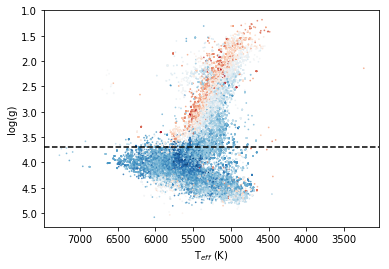

In [7]:
# Plot the position of the stars in a Teff-logg diagram
#plt.figure(figsize=(10,8))
plt.scatter(output_finalML2['Teff'].values, output_finalML2['logg'].values, s=0.5,rasterized=True, c=output_finalML2['feh'],alpha=0.8,edgecolors=None, cmap=plt.cm.RdBu)
plt.axhline(y=3.7, color='k', linestyle='--')
plt.xlabel('T$_{eff}$ (K)')
plt.ylabel('log(g)')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

In [10]:
###########
# Need to keep all these transformation => you should make the transformation subroutine
###########

colour_mean_logg = [input_finalML2[key].describe()['mean'] for key in input_finalML2]
colour_std_logg = [input_finalML2[key].describe()['std'] for key in input_finalML2]

mean_logg = output_finalML2['logg'].describe()['mean']
std_logg = output_finalML2['logg'].describe()['std']

error_logg_min=error_finalML2['dlogg'].describe()['min']
error_logg_max=error_finalML2['dlogg'].describe()['max']

stats_array = (input_finalML2, output_finalML2, error_finalML2)

# write final input and output dataframes to pickle file to load externally
with open('./stats_summary.pickle', 'r+') as f:
    pickle.dump(stats_array, f)

input_finalML2.sample(frac=1) # randomly shuffle order of pandas dataframe

# Normalize the data using custom normalize function
# default is using mean and stdev. Errors use min_max method
inputf = normalize(input_finalML2)
outputf = normalize(output_finalML2)
errorf = normalize(error_finalML2, 'min_max')

inputf_train = inputf.sample(frac=0.8, random_state=99)
inputf_test = inputf.loc[~inputf.index.isin(inputf_train.index), :]

outputf_train = outputf.sample(frac=0.8, random_state=99)
outputf_test = outputf.loc[~outputf.index.isin(outputf_train.index), :]

errorf_train = errorf.sample(frac=0.8, random_state=99)
errorf_test = outputf.loc[~errorf.index.isin(errorf_train.index), :]

train_frac = inputf_train.shape[0]/float(inputf.shape[0])
test_frac = inputf_test.shape[0]/float(inputf.shape[0])


print "Fraction of data for training:", train_frac
print "Fraction of data for testing:", test_frac
print "Check total is always 1.0:", train_frac+test_frac

Fraction of data for training: 0.8
Fraction of data for testing: 0.2
Check total is always 1.0: 1.0


In [11]:
x_train = inputf_train
y_train = outputf_train['logg_binary']

x_test = inputf_test
y_test = outputf_test['logg_binary']

x_error = errorf_test
y_error = errorf_train['dlogg']

In [12]:
from sklearn.naive_bayes import GaussianNB  
from sklearn.metrics import accuracy_score

# Initialize our classifier
gnb = GaussianNB()

# Train our classifier
model = gnb.fit(x_train, y_train)
preds = gnb.predict(x_test)
# Evaluate accuracy
print "Accuracy", accuracy_score(y_test, preds)

Accuracy 0.777256435321


In [ ]:
from keras.metrics import categorical_accuracy

seed = 7
np.random.seed(seed)

X = inputf.values.astype(float)
Y = outputf['logg_binary'].values

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(outputf['logg_binary'])
encoded_Y = encoder.transform(outputf['logg_binary'])

def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(32, input_dim=13, kernel_initializer='normal', activation='relu')) #v input_dim=13,
    model.add(Dense(5096, kernel_initializer='normal', activation='relu'))
    #model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

# evaluate model with standardized dataset
print "Baseline creation..."
estimator = KerasClassifier(build_fn=create_baseline, epochs=50, batch_size=1000, verbose=0)
kfold = StratifiedKFold(n_splits=3)
results = cross_val_score(estimator, X, encoded_Y, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Baseline creation...


Train on 61380 samples, validate on 15346 samples
Epoch 1/50
61380/61380 [==============================] - 9s 153us/step - loss: -2.4404 - acc: 0.0000e+00 - val_loss: -3.2154 - val_acc: 0.0000e+00
Epoch 2/50
61380/61380 [==============================] - 6s 100us/step - loss: -3.2787 - acc: 0.0000e+00 - val_loss: -3.2720 - val_acc: 0.0000e+00
Epoch 3/50
61380/61380 [==============================] - 6s 101us/step - loss: -3.3452 - acc: 0.0000e+00 - val_loss: -3.4387 - val_acc: 0.0000e+00
Epoch 4/50
61380/61380 [==============================] - 6s 104us/step - loss: -3.4473 - acc: 0.0000e+00 - val_loss: -3.5997 - val_acc: 0.0000e+00
Epoch 5/50
61380/61380 [==============================] - 7s 108us/step - loss: -3.5060 - acc: 0.0000e+00 - val_loss: -3.5300 - val_acc: 0.0000e+00
Epoch 6/50
61380/61380 [==============================] - 6s 98us/step - loss: -3.5541 - acc: 0.0000e+00 - val_loss: -3.4945 - val_acc: 0.0000e+00
Epoch 7/50
61380/61380 [==============================] - 6s 10

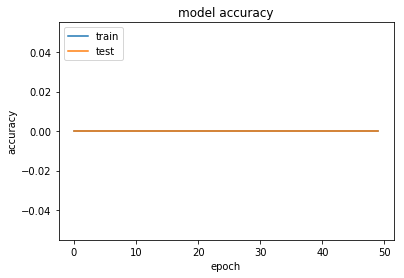

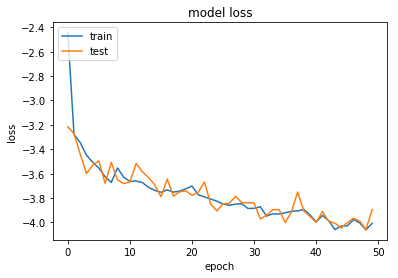

In [76]:
# The below code isn't quite working as it should yet....


#history = model.fit(inputf_train, outputf_train['logg'], validation_data=(inputf_test,outputf_test['logg']), epochs=50, batch_size=500)

history = create_baseline().fit(X, Y, validation_split=0.20, epochs=50, batch_size=500, verbose=1)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import seaborn as sns  

correlation = df_original.corr()  
plt.figure(figsize=(25, 25))  
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')
plt.savefig('correlation.pdf')